In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/optiver-trading-at-the-close/public_timeseries_testing_util.py
/kaggle/input/optiver-trading-at-the-close/train.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/sample_submission.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv
/kaggle/input/optiver-trading-at-the-close/optiver2023/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/optiver-trading-at-the-close/optiver2023/__init__.py


In [6]:
import pandas as pd

# Chemins des fichiers
train_file = '/kaggle/input/optiver-trading-at-the-close/train.csv'
sample_submission_file = '/kaggle/input/optiver-trading-at-the-close/example_test_files/sample_submission.csv'
revealed_targets_file = '/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv'
test_file = '/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv'

# Charger les données dans des DataFrames pandas
train = pd.read_csv(train_file)
sample_submission = pd.read_csv(sample_submission_file)
revealed_targets = pd.read_csv(revealed_targets_file)
test = pd.read_csv(test_file)


In [7]:
column_names = [column for column in train]
print(column_names)

['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag', 'reference_price', 'matched_size', 'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap', 'target', 'time_id', 'row_id']


In [8]:
print(train.info(), train.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 679.4+ MB
None            stock_id       date_id  seconds_in_bucket  imbalance_size  \
count  5.237980e+06  5.

In [9]:
 (train.isnull().sum()*100/5237980).mean()

6.46065176000717

Avec environ 6.5% de valeurs manquantes, nous devons trouver une bonne méthode pour amputer ces données, car leur suppression peut grandement biaiser notre futur modéle.

In [10]:
train.isnull().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

On constate que les variables imbalance_size, reference_price, matched_size, bid_price, ask_price, wap, target ont peu de valeurs manquantes, donc on pourra les remplacer par la moyenne ou la médiane.
Pour ce qui est de far_price et near_price qui ont un grand nombre de NA, on utilisera une imputation par interpolation si les données sont chronologiques.

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

### Vérifins si 'date_id', 'time_id' sont chronologiques

In [12]:
print(train[['date_id', 'time_id']].head())

# Trier les données par date_id et time_id
train_sorted = train.sort_values(by=['date_id', 'time_id'])

# Vérifier si les données sont déjà triées de manière chronologique
is_chronological = train.equals(train_sorted)
print(f"Les données sont-elles chronologiques ? {is_chronological}")

# Vérifier la monotonie des colonnes temporelles
is_date_id_monotonic = train['date_id'].is_monotonic_increasing
is_time_id_monotonic = train['time_id'].is_monotonic_increasing
print(f"date_id est-il monotone ? {is_date_id_monotonic}")
print(f"time_id est-il monotone ? {is_time_id_monotonic}")


   date_id  time_id
0        0        0
1        0        0
2        0        0
3        0        0
4        0        0
Les données sont-elles chronologiques ? True
date_id est-il monotone ? True
time_id est-il monotone ? True


Les résultats précédents confirment bien que nos données sont chronologiques et nomotones. Utilisons donc une interpolation pour les imputer.

## Amputation des données

In [13]:
# Créer une copie du DataFrame original
train_imputed = train.copy()

# Imputation par la médiane pour les colonnes avec peu de valeurs manquantes
train_imputed['imbalance_size'] = train['imbalance_size'].fillna(train['imbalance_size'].median())
train_imputed['reference_price'] = train['reference_price'].fillna(train['reference_price'].median())
train_imputed['matched_size'] = train['matched_size'].fillna(train['matched_size'].median())
train_imputed['bid_price'] = train['bid_price'].fillna(train['bid_price'].median())
train_imputed['ask_price'] = train['ask_price'].fillna(train['ask_price'].median())
train_imputed['wap'] = train['wap'].fillna(train['wap'].median())
train_imputed['target'] = train['target'].fillna(train['target'].median())

print(train_imputed.isnull().sum())

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                   0
imbalance_buy_sell_flag          0
reference_price                  0
matched_size                     0
far_price                  2894342
near_price                 2857180
bid_price                        0
bid_size                         0
ask_price                        0
ask_size                         0
wap                              0
target                           0
time_id                          0
row_id                           0
dtype: int64


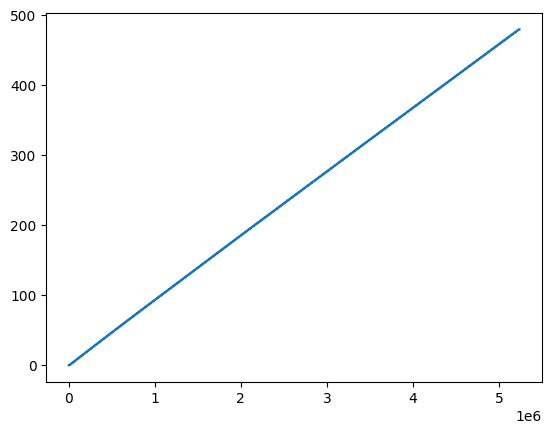

In [14]:
plt.plot(train_imputed['date_id'])

0         -3.029704
1         -5.519986
2         -8.389950
3         -4.010200
4         -7.349849
             ...   
5237975    2.310276
5237976   -8.220077
5237977    1.169443
5237978   -1.540184
5237979   -6.530285
Name: target, Length: 5237980, dtype: float64


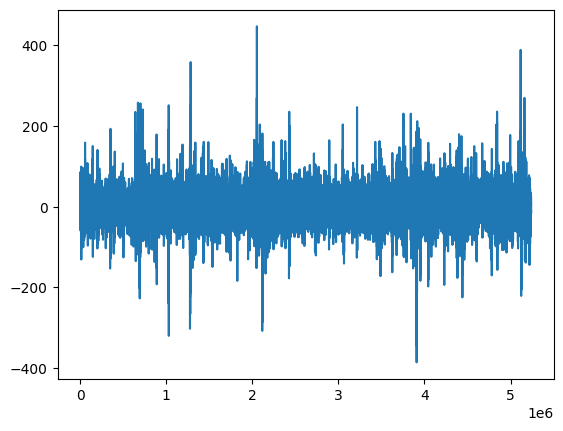

In [15]:
print(train_imputed['target'])
plt.plot(train_imputed['target'])

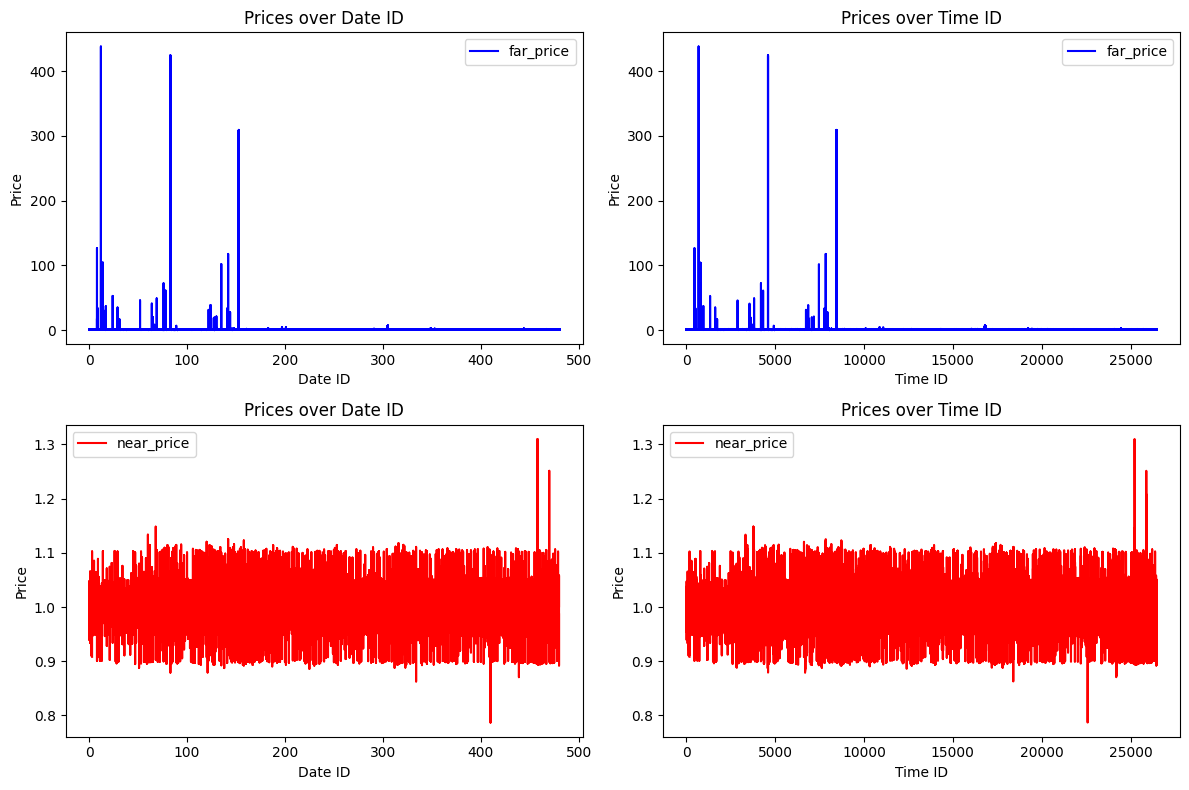

In [16]:
# Création de la figure et des sous-graphiques
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot 1
axs[0, 0].plot(train['date_id'], train['far_price'], label='far_price', color='blue')
axs[0, 0].set_xlabel('Date ID')
axs[0, 0].set_ylabel('Price')
axs[0, 0].set_title('Prices over Date ID')
axs[0, 0].legend()

# Plot 2
axs[0, 1].plot(train['time_id'], train['far_price'], label='far_price', color='blue')
axs[0, 1].set_xlabel('Time ID')
axs[0, 1].set_ylabel('Price')
axs[0, 1].set_title('Prices over Time ID')
axs[0, 1].legend()

# Plot 3
axs[1, 0].plot(train['date_id'], train['near_price'], label='near_price', color='red')
axs[1, 0].set_xlabel('Date ID')
axs[1, 0].set_ylabel('Price')
axs[1, 0].set_title('Prices over Date ID')
axs[1, 0].legend()

# Plot 4
axs[1, 1].plot(train['time_id'], train['near_price'], label='near_price', color='red')
axs[1, 1].set_xlabel('Time ID')
axs[1, 1].set_ylabel('Price')
axs[1, 1].set_title('Prices over Time ID')
axs[1, 1].legend()

plt.tight_layout()  # Réglage automatique de l'espacement

plt.show()


In [17]:
# Interpolation linéaire pour far_price
train_imputed['far_price'] = train['far_price'].interpolate(method='linear')

# Interpolation linéaire pour near_price
train_imputed['near_price'] = train['near_price'].interpolate(method='linear')


In [18]:
train_imputed['far_price']
print(train_imputed.isnull().sum())

stock_id                      0
date_id                       0
seconds_in_bucket             0
imbalance_size                0
imbalance_buy_sell_flag       0
reference_price               0
matched_size                  0
far_price                  5730
near_price                 5730
bid_price                     0
bid_size                      0
ask_price                     0
ask_size                      0
wap                           0
target                        0
time_id                       0
row_id                        0
dtype: int64


Après amputations, nous n'avons plus beaucoup de données manquantes et nous pouvons donc commencer à modéliser.

In [19]:
print(test.describe(), test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   stock_id                 33000 non-null  int64  
 1   date_id                  33000 non-null  int64  
 2   seconds_in_bucket        33000 non-null  int64  
 3   imbalance_size           33000 non-null  float64
 4   imbalance_buy_sell_flag  33000 non-null  int64  
 5   reference_price          33000 non-null  float64
 6   matched_size             33000 non-null  float64
 7   far_price                14771 non-null  float64
 8   near_price               15000 non-null  float64
 9   bid_price                33000 non-null  float64
 10  bid_size                 33000 non-null  float64
 11  ask_price                33000 non-null  float64
 12  ask_size                 33000 non-null  float64
 13  wap                      33000 non-null  float64
 14  time_id               

In [20]:
test_imputed = test.copy() 

test_imputed['far_price'] = test['far_price'].interpolate(method='linear')

# Interpolation linéaire pour near_price
test_imputed['near_price'] = test['near_price'].interpolate(method='linear')

In [21]:
test_imputed.isna().sum()
#test.isna().sum()

stock_id                      0
date_id                       0
seconds_in_bucket             0
imbalance_size                0
imbalance_buy_sell_flag       0
reference_price               0
matched_size                  0
far_price                  6000
near_price                 6000
bid_price                     0
bid_size                      0
ask_price                     0
ask_size                      0
wap                           0
time_id                       0
row_id                        0
currently_scored              0
dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


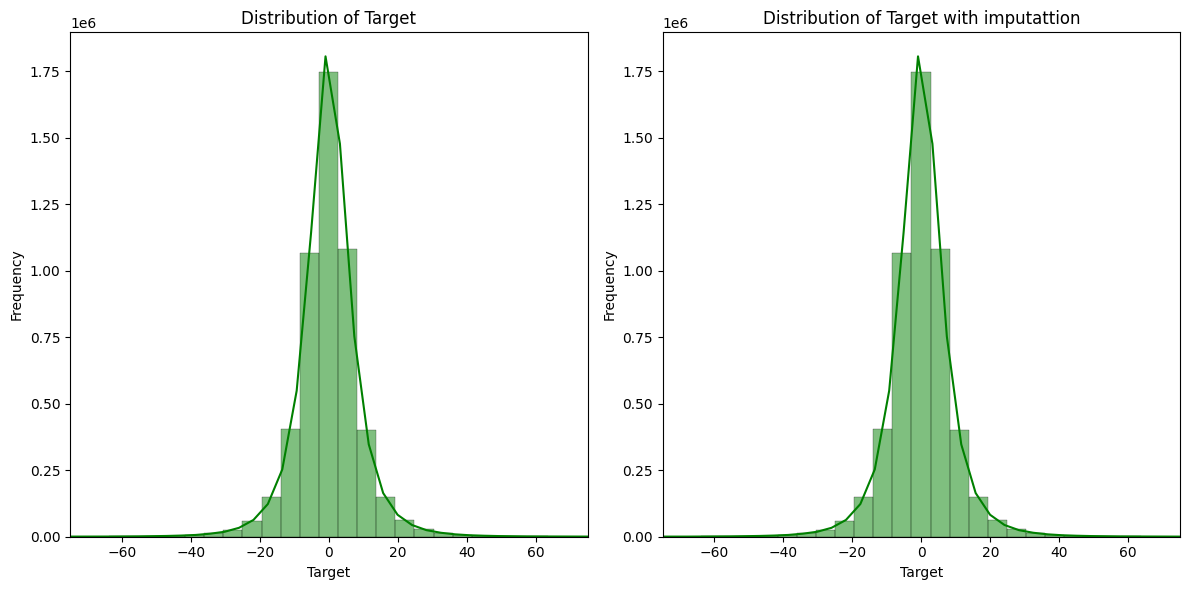

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Tracer l'histogramme à gauche
sns.histplot(train['target'], color='g', bins=150, kde=True, ax=axes[0])
axes[0].set_xlim([-75, 75])
axes[0].set_xlabel('Target')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Target')

# Tracer l'histogramme à droite
sns.histplot(train_imputed['target'], color='g', bins=150, kde=True, ax=axes[1])
axes[1].set_xlim([-75, 75])
axes[1].set_xlabel('Target')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Target with imputattion')

plt.tight_layout()  # Réglage automatique de l'espacement

plt.show()


On voit bien que nos prix à la fermeture suivent une normale centrée réduite. Et aussi il n'ya pas une très grande différence avant et après imputation car on a vait très peu de valeurrs NA dans cette variable.

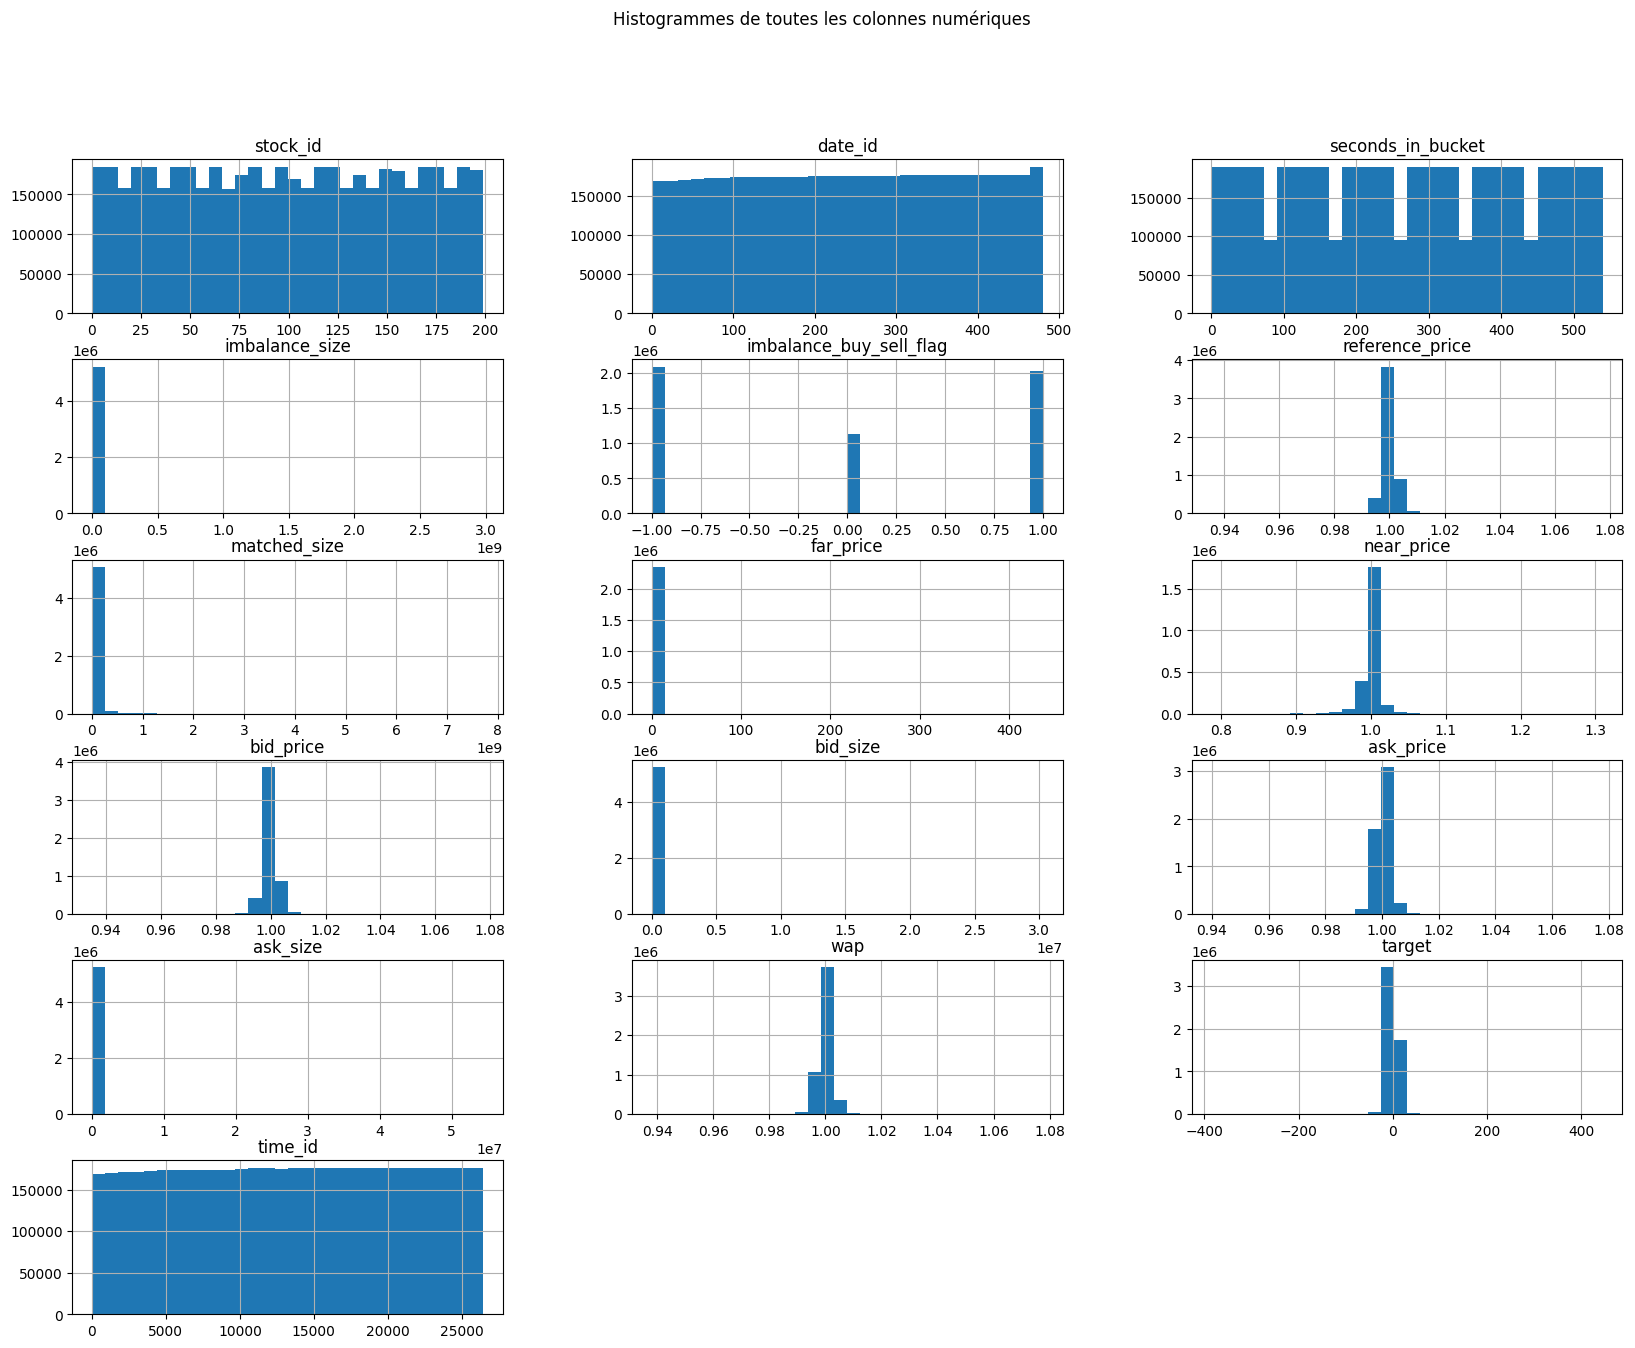

In [23]:
# Filtrer uniquement les colonnes numériques
numeric_columns = train.select_dtypes(include=['float64', 'int64']).columns

# Créer un histogramme pour chaque colonne numérique
train[numeric_columns].hist(bins=30, figsize=(20, 15), layout=(6, 3))
plt.suptitle('Histogrammes de toutes les colonnes numériques')
plt.show()

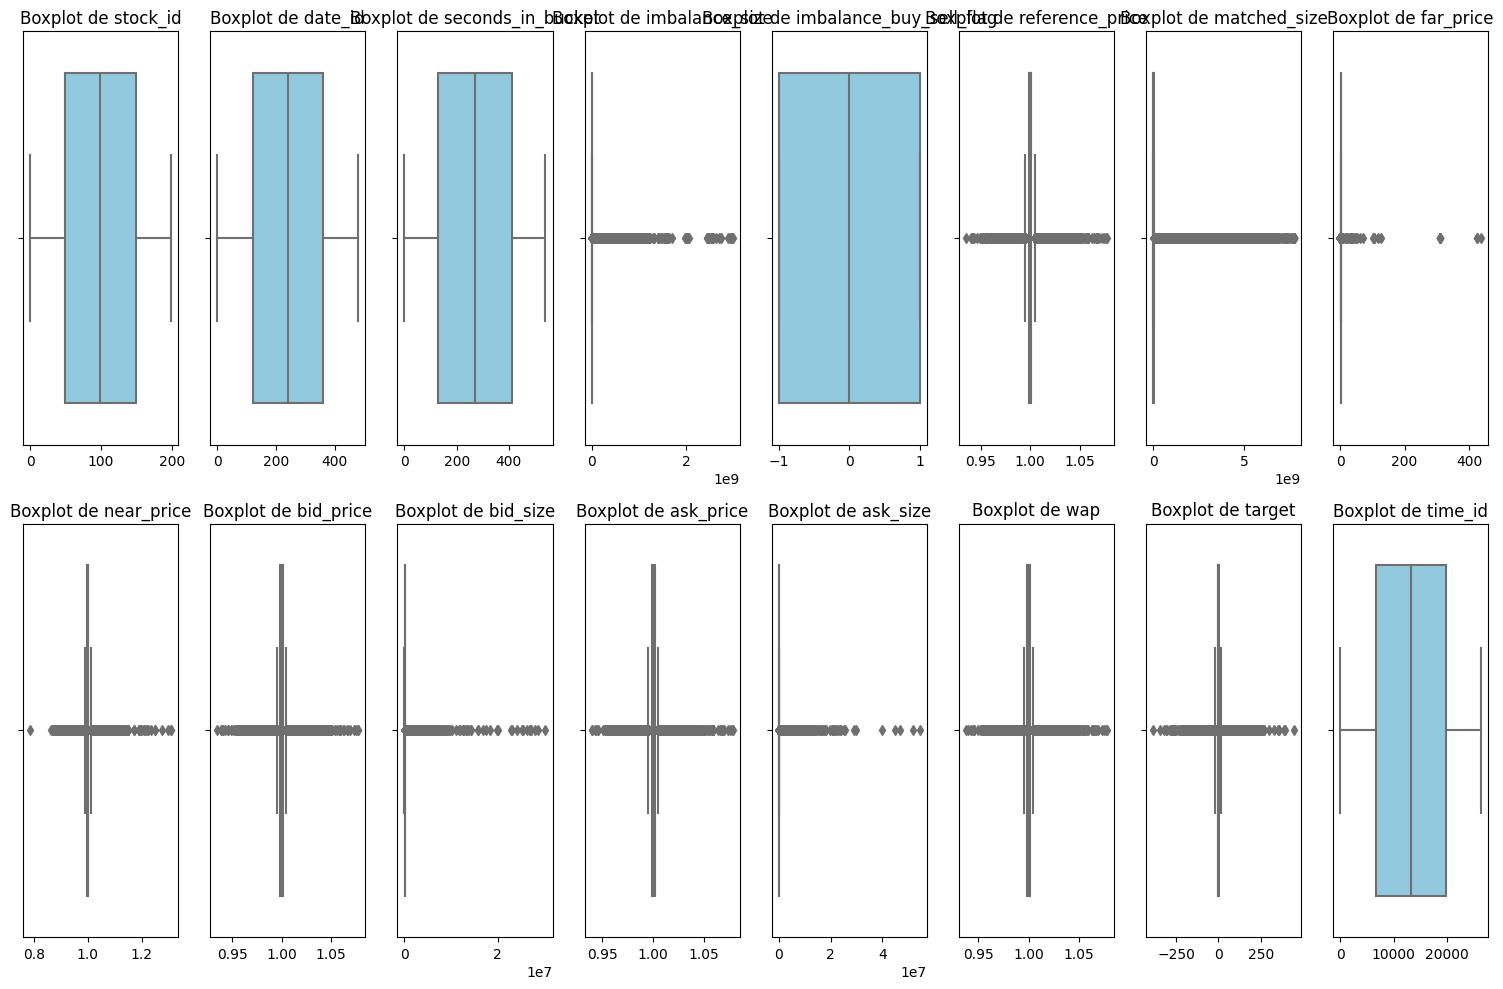

In [24]:
# Créer un boxplot pour chaque colonne numérique sur son propre graphe
plt.figure(figsize=(15, 10))
for i, column in enumerate(numeric_columns):
    plt.subplot(2, len(numeric_columns)//2, i+1)  # Créer un sous-graphique
    sns.boxplot(x=train[column], color='skyblue')  # Créer le boxplot
    plt.title(f'Boxplot de {column}')  # Ajouter un titre
    plt.xlabel('') 
plt.tight_layout() 
plt.show()

Ces graphes nous montrent qu'ils des valeurs aberrantes, et la variable second_in_bucket est périodique. La variable inbalance_buy_sell_flag est categorielle.

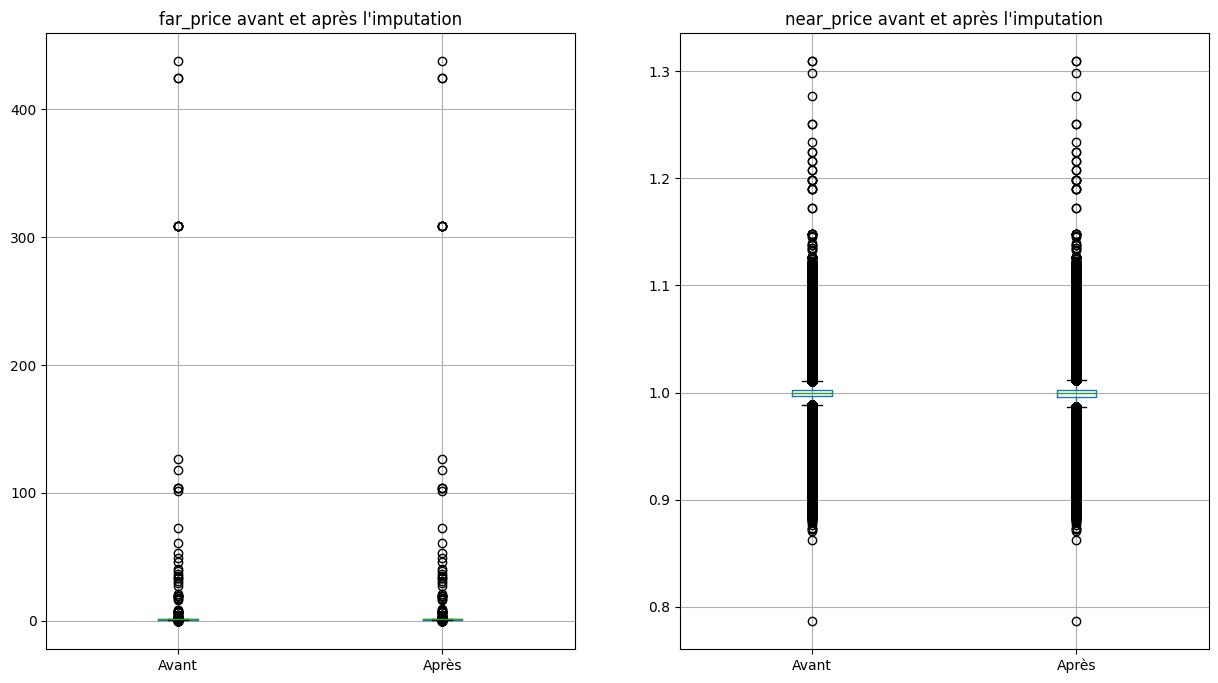

In [25]:
price_data = pd.DataFrame({
    'near_price_train': train['near_price'],
    'far_price_train': train['far_price'],
    'near_price_imputed': train_imputed['near_price'],
    'far_price_imputed': train_imputed['far_price']
})

plt.figure(figsize=(15, 8))

#pour far_price
plt.subplot(1, 2, 1)  
price_data[['far_price_train', 'far_price_imputed']].boxplot()
plt.title('far_price avant et après l\'imputation')
plt.xticks([1, 2], ['Avant', 'Après'])  # Étiquettes pour les colonnes

##pour near_price
plt.subplot(1, 2, 2)  
price_data[['near_price_train', 'near_price_imputed']].boxplot()
plt.title('near_price avant et après l\'imputation')
plt.xticks([1, 2], ['Avant', 'Après'])  # Étiquettes pour les colonnes

plt.show()

Là nous voyons que ces deux variables ont beaucoup de valeurs aberrantes et celles-ci pourraient fausser ou biaiser notre analyse. Nous allons donc supprimer quelques unes.

In [26]:
train_imputed

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


En reagardant les donnes je constate que stock_id, date_id et seconds_in_bucket forment row_id de cette facon date_id_seconds_in_bucket_stock_id. 

### Matrice de confusion

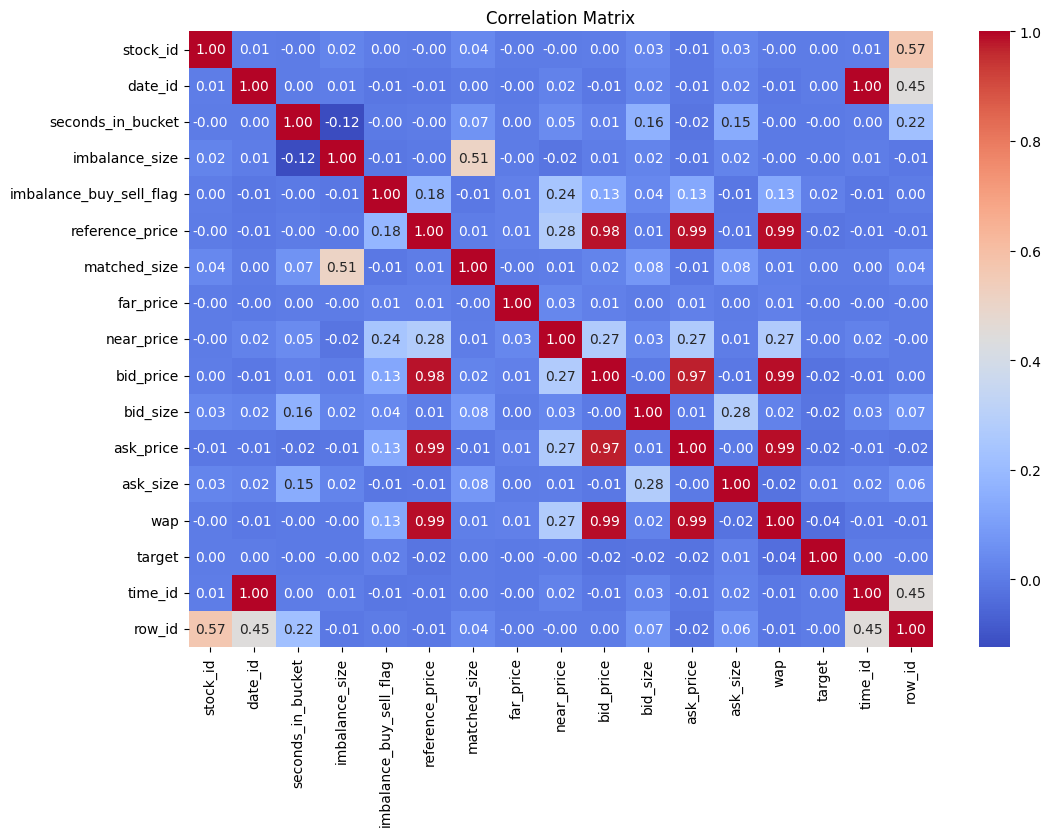

In [27]:
correlation_matrix = train_imputed.corr()

plt.figure(figsize=(12, 8))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Correlation Matrix')

# Afficher le graphique
plt.show()

Cette matrice nous montre que beaucoup de variables sont correlées. ¨Par exemple reference_price, bid_price, wap et ask_price sont fortement correlées; idem pour date_id et time_id; imbalance_size et matched_size sont correlées; nous avons aussi near_price dont la correlation n'est pas négligeable avec reference_price, imbalance_buy_sell_flag, bid_price, ask_price et wap .

# Modélisation

In [28]:
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb

In [32]:
y_train = train_imputed['target']
#X_train_filtered = X_train.drop(columns=['row_id'])
X_train = train_imputed.drop(columns=['target', 'row_id'])
X_test = test_imputed.drop(columns=['row_id'])

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
#train_imputed

In [33]:
model = CatBoostRegressor(
    iterations=300,
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=3.0,
    loss_function='MAE',
    verbose=30)  # Créez un modèle CatBoostRegressor

model.fit(X_train, y_train)  # Entraînez le modèle sur les données d'entraînement

#importance des caractéristiques
feature_importances = model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

0:	learn: 6.4033288	total: 881ms	remaining: 4m 23s
30:	learn: 6.3606297	total: 21.6s	remaining: 3m 7s
60:	learn: 6.3478414	total: 41.7s	remaining: 2m 43s
90:	learn: 6.3406642	total: 1m 1s	remaining: 2m 21s
120:	learn: 6.3351053	total: 1m 21s	remaining: 2m
150:	learn: 6.3303887	total: 1m 41s	remaining: 1m 39s
180:	learn: 6.3269726	total: 2m	remaining: 1m 19s
210:	learn: 6.3238306	total: 2m 19s	remaining: 58.9s
240:	learn: 6.3210292	total: 2m 39s	remaining: 39s
270:	learn: 6.3183257	total: 2m 58s	remaining: 19.1s
299:	learn: 6.3162108	total: 3m 16s	remaining: 0us


In [34]:
selected_features = feature_importance_df['Feature'].tolist()[:10]
X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]
print(X_train_selected.shape)

(4190384, 10)


In [35]:
model_selected = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=3.0,
    loss_function='MAE',
    verbose=100
)

model_selected.fit(X_train_selected, y_train)

# Obtenez les prédictions et le MAE pour les caractéristiques sélectionnées
y_pred_selected = model_selected.predict(X_val_selected)
mae_selected = mean_absolute_error(y_val, y_pred_selected)
print(f'MAE on validation set with selected features: {mae_selected}')

0:	learn: 6.4033385	total: 746ms	remaining: 12m 25s
100:	learn: 6.3387199	total: 1m 2s	remaining: 9m 19s
200:	learn: 6.3245101	total: 2m 2s	remaining: 8m 7s
300:	learn: 6.3154652	total: 3m 3s	remaining: 7m 6s
400:	learn: 6.3086491	total: 4m 2s	remaining: 6m 2s
500:	learn: 6.3031687	total: 5m 2s	remaining: 5m
600:	learn: 6.2985878	total: 5m 59s	remaining: 3m 58s
700:	learn: 6.2946589	total: 6m 57s	remaining: 2m 58s
800:	learn: 6.2911820	total: 7m 55s	remaining: 1m 58s
900:	learn: 6.2882077	total: 8m 54s	remaining: 58.8s
999:	learn: 6.2854889	total: 9m 52s	remaining: 0us
MAE on validation set with selected features: 6.297720449253762


In [36]:
y_pred = model.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
print(f'MAE on validation set with selected features: {mae}')

MAE on validation set with selected features: 6.324374621300273


Optimisation d'hyperparam

In [37]:
pip install scikit-optimize

Note: you may need to restart the kernel to use updated packages.


In [35]:
# Définir l'espace des hyperparamètres à rechercher
param_space = {
    'iterations': (500, 1000),  # Nombre d'itérations
    'learning_rate': (0.01, 0.3, 'log-uniform'),  # Taux d'apprentissage
    'depth': (3, 10),  # Profondeur de l'arbre
    'l2_leaf_reg': (1, 10),  # Régularisation L2
}

# Définir le modèle
model = CatBoostRegressor(loss_function='MAE', verbose=100)

# Effectuer la recherche aléatoire
search = BayesSearchCV(model, param_space, n_iter=10, cv=3, scoring='neg_mean_absolute_error', random_state=42)
search.fit(X_train_selected, y_train)

# Afficher les meilleurs paramètres et la performance
print("Meilleurs paramètres:", search.best_params_)
print("MAE avec les meilleurs paramètres:", -search.best_score_)

# Évaluer le modèle sur l'ensemble de validation
y_pred = search.best_estimator_.predict(X_val_selected)
mae = mean_absolute_error(y_val, y_pred)
print("MAE sur l'ensemble de validation:", mae)

0:	learn: 6.4050344	total: 542ms	remaining: 7m 48s
100:	learn: 6.3415247	total: 44.3s	remaining: 5m 34s
200:	learn: 6.3267633	total: 1m 26s	remaining: 4m 46s
300:	learn: 6.3176024	total: 2m 10s	remaining: 4m 3s
400:	learn: 6.3105687	total: 2m 52s	remaining: 3m 19s
500:	learn: 6.3049055	total: 3m 34s	remaining: 2m 35s
600:	learn: 6.2999634	total: 4m 16s	remaining: 1m 52s
700:	learn: 6.2956882	total: 4m 58s	remaining: 1m 9s
800:	learn: 6.2918964	total: 5m 39s	remaining: 26.7s
863:	learn: 6.2896305	total: 6m 6s	remaining: 0us
0:	learn: 6.4059917	total: 443ms	remaining: 6m 22s
100:	learn: 6.3420833	total: 43.7s	remaining: 5m 30s
200:	learn: 6.3274036	total: 1m 26s	remaining: 4m 45s
300:	learn: 6.3180878	total: 2m 9s	remaining: 4m 2s
400:	learn: 6.3112450	total: 2m 51s	remaining: 3m 18s
500:	learn: 6.3053428	total: 3m 34s	remaining: 2m 35s
600:	learn: 6.3004285	total: 4m 14s	remaining: 1m 51s
700:	learn: 6.2962703	total: 4m 55s	remaining: 1m 8s
800:	learn: 6.2924937	total: 5m 37s	remaining:

Meilleurs paramètres: OrderedDict([('depth', 9), ('iterations', 942), ('l2_leaf_reg', 4), ('learning_rate', 0.2541400145361314)])
MAE avec les meilleurs paramètres: 6.250295942670189
MAE sur l'ensemble de validation: 6.243025914454114

#MODELE LGBM

In [36]:
# Définir les paramètres du modèle
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'num_leaves': 31,
    'learning_rate': 0.03,
    'max_depth': 6,
    'reg_lambda': 3.0,
    'verbose': 10
}

# Créer un jeu de données LGBM
train_data = lgb.Dataset(X_train_selected, label=y_train)

# Entraîner le modèle
model_selected = lgb.train(params, train_data, num_boost_round=100)

# Faire des prédictions sur l'ensemble de validation
y_pred_selected = model_selected.predict(X_val_selected)

# Calculer le MAE
mae_selected = mean_absolute_error(y_val, y_pred_selected)
print(f'MAE on validation set with selected features: {mae_selected}')


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.045093
[LightGBM] [Debug] init for col-wise cost 0.001273 seconds, init for row-wise cost 0.213641 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.326322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 4190384, number of used features: 10
[LightGBM] [Info] Start training from score -0.051737
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trai

In [88]:
from skopt import BayesSearchCV
import lightgbm as lgb


# Définir l'espace des hyperparamètres à rechercher
param_space = {
    'num_leaves': (10, 100),
    'learning_rate': (0.001, 0.1, 'log-uniform'),
    'max_depth': (3, 15),
    'reg_lambda': (0.01, 10.0, 'log-uniform')
}

# Définir le modèle
model = lgb.LGBMRegressor()

# Effectuer la recherche aléatoire
search = BayesSearchCV(model, param_space, n_iter=10, cv=3, scoring='neg_mean_absolute_error', random_state=42)
search.fit(X_train_selected, y_train)

# Afficher les meilleurs paramètres et la performance
print("Meilleurs paramètres:", search.best_params_)
print("MAE avec les meilleurs paramètres:", -search.best_score_)

# Évaluer le modèle sur l'ensemble de validation
y_pred = search.best_estimator_.predict(X_val_selected)
mae = mean_absolute_error(y_val, y_pred)
print("MAE sur l'ensemble de validation:", mae)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.646429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 2793589, number of used features: 10
[LightGBM] [Info] Start training from score -0.049275
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.644651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 2793589, number of used features: 10
[LightGBM] [Info] Start training from score -0.052141
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.674637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 2793590, number of used features: 10
[LightGBM] [Info] S

Meilleurs paramètres: OrderedDict([('learning_rate', 0.1), ('max_depth', 9), ('num_leaves', 100), ('reg_lambda', 10.0)])

# STACKING 

Meilleurs paramètres: OrderedDict([('depth', 9), ('iterations', 942), ('l2_leaf_reg', 4), ('learning_rate', 0.2541400145361314)])
MAE avec les meilleurs paramètres: 6.250295942670189
MAE sur l'ensemble de validation: 6.243025914454114

In [43]:
from sklearn.ensemble import StackingRegressor, VotingRegressor

# Définir les modèles de base
catboost_model = CatBoostRegressor(
    iterations=942,
    learning_rate=0.2541400145361314,
    depth=9,
    l2_leaf_reg=4.0,
    loss_function='MAE',
    verbose=100
)

lgb_model = lgb.LGBMRegressor(
    boosting_type='gbdt',
    objective='regression',
    num_leaves=100,
    learning_rate=0.1,
    max_depth=9,
    reg_lambda=10.0,
    verbose=100
)

catboost_model.fit(X_train_selected, y_train)
lgb_model.fit(X_train_selected, y_train)

0:	learn: 6.3830301	total: 827ms	remaining: 12m 58s
100:	learn: 6.2593783	total: 1m 13s	remaining: 10m 12s
200:	learn: 6.2243852	total: 2m 25s	remaining: 8m 55s
300:	learn: 6.1967002	total: 3m 36s	remaining: 7m 42s
400:	learn: 6.1731621	total: 4m 48s	remaining: 6m 29s
500:	learn: 6.1535003	total: 5m 59s	remaining: 5m 16s
600:	learn: 6.1344075	total: 7m 10s	remaining: 4m 4s
700:	learn: 6.1171244	total: 8m 21s	remaining: 2m 52s
800:	learn: 6.1011876	total: 9m 32s	remaining: 1m 40s
900:	learn: 6.0859927	total: 10m 42s	remaining: 29.2s
941:	learn: 6.0802350	total: 11m 12s	remaining: 0us
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.045093
[LightGBM] [Debug] init for col-wise cost 0.001590 seconds, init for row-wise cost 0.339861 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.531886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data poin

LGBMRegressor(max_depth=9, num_leaves=100, objective='regression',
              reg_lambda=10.0, verbose=100)

In [53]:
# Définir les modèles pour le stacking

# Définir les modèles pour le stacking
estimators0 = [
    ('lightgbm', lgb_model)
]

# Créer un modèle de stacking avec CatBoost comme méta-modèle
stacking_model = StackingRegressor(
    estimators=estimators0,
    final_estimator=catboost_model
)

# Entraîner le modèle de stacking
stacking_model.fit(X_train_selected, y_train)

# Faire des prédictions sur l'ensemble de validation
y_pred = stacking_model.predict(X_val_selected)

# Calculer le MAE
mae = mean_absolute_error(y_val, y_pred)
print(f'MAE on validation set with stacking model: {mae}')

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.045093
[LightGBM] [Debug] init for col-wise cost 0.000005 seconds, init for row-wise cost 0.655683 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.028234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 4190384, number of used features: 10
[LightGBM] [Info] Start training from score -0.051737
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 9
[LightGBM] [Debu

In [55]:
stacking_model.fit(X_train, y_train)
# Faire des prédictions sur l'ensemble d'entrainement
y_pred_stack_train = stacking_model.predict(X_train)

# Calculer le MAE
mae_stack_train = mean_absolute_error(y_train, y_pred_stack_train)
print(f'MAE on validation set with stacking model: {mae_stack_train}')

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.030540
[LightGBM] [Debug] init for col-wise cost 0.000006 seconds, init for row-wise cost 0.861134 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.415780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3317
[LightGBM] [Info] Number of data points in the train set: 4190384, number of used features: 15
[LightGBM] [Info] Start training from score -0.051737
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 9
[LightGBM] [Debu

In [45]:
# Faire des prédictions sur l'ensemble d'entrainement
y_pred_cat_train = catboost_model.predict(X_train)

# Calculer le MAE
mae_cat_train = mean_absolute_error(y_train, y_pred_cat_train)
print(f'MAE on train set with catboost model: {mae_cat_train}')

MAE on validation set with catboost model: 6.080235990591364


In [49]:
# Faire des prédictions sur l'ensemble d'entrainement
lgb_model.fit(X_train, y_train)
y_pred_lgb_train = lgb_model.predict(X_train)

# Calculer le MAE
mae_lgb_train = mean_absolute_error(y_train, y_pred_lgb_train)
print(f'MAE on trainset with lightgbm model: {mae_lgb_train}')

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.030540
[LightGBM] [Debug] init for col-wise cost 0.000007 seconds, init for row-wise cost 0.847570 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.403170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3317
[LightGBM] [Info] Number of data points in the train set: 4190384, number of used features: 15
[LightGBM] [Info] Start training from score -0.051737
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 100 and depth = 9
[LightGBM] [Debu

In [50]:
estimators = [
    ('catboost', catboost_model),
    ('lightgbm', lgb_model)
]
# Créer un modèle de voting
voting_model = VotingRegressor(estimators=estimators)

# Entraîner le modèle de voting
voting_model.fit(X_train_selected, y_train)

# Faire des prédictions sur l'ensemble de validation
y_pred_voting = voting_model.predict(X_val_selected)

# Calculer le MAE
mae_voting = mean_absolute_error(y_val, y_pred_voting)
print(f'MAE on validation set with voting model: {mae_voting}')


0:	learn: 6.3830301	total: 863ms	remaining: 13m 31s
100:	learn: 6.2593783	total: 1m 13s	remaining: 10m 10s
200:	learn: 6.2243852	total: 2m 24s	remaining: 8m 51s
300:	learn: 6.1967002	total: 3m 35s	remaining: 7m 39s
400:	learn: 6.1731621	total: 4m 47s	remaining: 6m 28s
500:	learn: 6.1535003	total: 5m 58s	remaining: 5m 15s
600:	learn: 6.1344075	total: 7m 9s	remaining: 4m 3s
700:	learn: 6.1171244	total: 8m 20s	remaining: 2m 52s
800:	learn: 6.1011876	total: 9m 31s	remaining: 1m 40s
900:	learn: 6.0859927	total: 10m 42s	remaining: 29.2s
941:	learn: 6.0802350	total: 11m 11s	remaining: 0us
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.045093
[LightGBM] [Debug] init for col-wise cost 0.000007 seconds, init for row-wise cost 0.685633 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.057256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data point

In [52]:
voting_model.fit(X_train, y_train)
# Faire des prédictions sur l'ensemble d'entrainement
y_pred_voting_train = voting_model.predict(X_train)

# Calculer le MAE
mae_voting_train = mean_absolute_error(y_train, y_pred_voting_train)
print(f'MAE on train set with voting model: {mae_voting_train}')

0:	learn: 6.3825737	total: 973ms	remaining: 15m 15s
100:	learn: 6.2466723	total: 1m 22s	remaining: 11m 28s
200:	learn: 6.1981489	total: 2m 41s	remaining: 9m 55s
300:	learn: 6.1576860	total: 4m	remaining: 8m 33s
400:	learn: 6.1237768	total: 5m 21s	remaining: 7m 13s
500:	learn: 6.0911044	total: 6m 40s	remaining: 5m 52s
600:	learn: 6.0616636	total: 7m 59s	remaining: 4m 31s
700:	learn: 6.0344080	total: 9m 18s	remaining: 3m 11s
800:	learn: 6.0093614	total: 10m 37s	remaining: 1m 52s
900:	learn: 5.9845810	total: 11m 56s	remaining: 32.6s
941:	learn: 5.9750234	total: 12m 29s	remaining: 0us
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.030540
[LightGBM] [Debug] init for col-wise cost 0.000006 seconds, init for row-wise cost 0.869362 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.423662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3317
[LightGBM] [Info] Number of data points

#MODELE TRANSFORMER